#  Wine Classification – MLOps Pipeline  
Autor: **Karen Espejo Herrera**

Este notebook implementa un flujo completo de Machine Learning con prácticas MLOps, incluyendo:          - Exploración y validación de datos
- Análisis de correlaciones y outliers
- Preprocesamiento profesional
- Modelo basado en Random Forest con pipeline
- Registro en MLflow
- Predicción final para las muestras solicitadas

El objetivo es predecir la **variedad de uva** en el dataset de vinos de UCI.

In [0]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
df = pd.read_csv(url, header=None)

df.columns = [
    "class","alcohol","malic_acid","ash","alcalinity_of_ash","magnesium",
    "total_phenols","flavanoids","nonflavanoid_phenols","proanthocyanins",
    "color_intensity","hue","od280_od315","proline"
]

df.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Exploración inicial de la estructura del dataset

Se revisa que el dataset no contenga valores nulos, tipos inconsistentes o columnas faltantes.

In [0]:
df.info(), df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 178 non-null    int64  
 1   alcohol               178 non-null    float64
 2   malic_acid            178 non-null    float64
 3   ash                   178 non-null    float64
 4   alcalinity_of_ash     178 non-null    float64
 5   magnesium             178 non-null    int64  
 6   total_phenols         178 non-null    float64
 7   flavanoids            178 non-null    float64
 8   nonflavanoid_phenols  178 non-null    float64
 9   proanthocyanins       178 non-null    float64
 10  color_intensity       178 non-null    float64
 11  hue                   178 non-null    float64
 12  od280_od315           178 non-null    float64
 13  proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


(None,
 class                   0
 alcohol                 0
 malic_acid              0
 ash                     0
 alcalinity_of_ash       0
 magnesium               0
 total_phenols           0
 flavanoids              0
 nonflavanoid_phenols    0
 proanthocyanins         0
 color_intensity         0
 hue                     0
 od280_od315             0
 proline                 0
 dtype: int64)

In [0]:
df.describe()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


## Conversión de tipos numéricos

Dado que MLflow advierte cuando existen columnas enteras que podrían contener valores nulos en inferencias futuras.  
Se convierten a `float` para evitar errores de esquema.

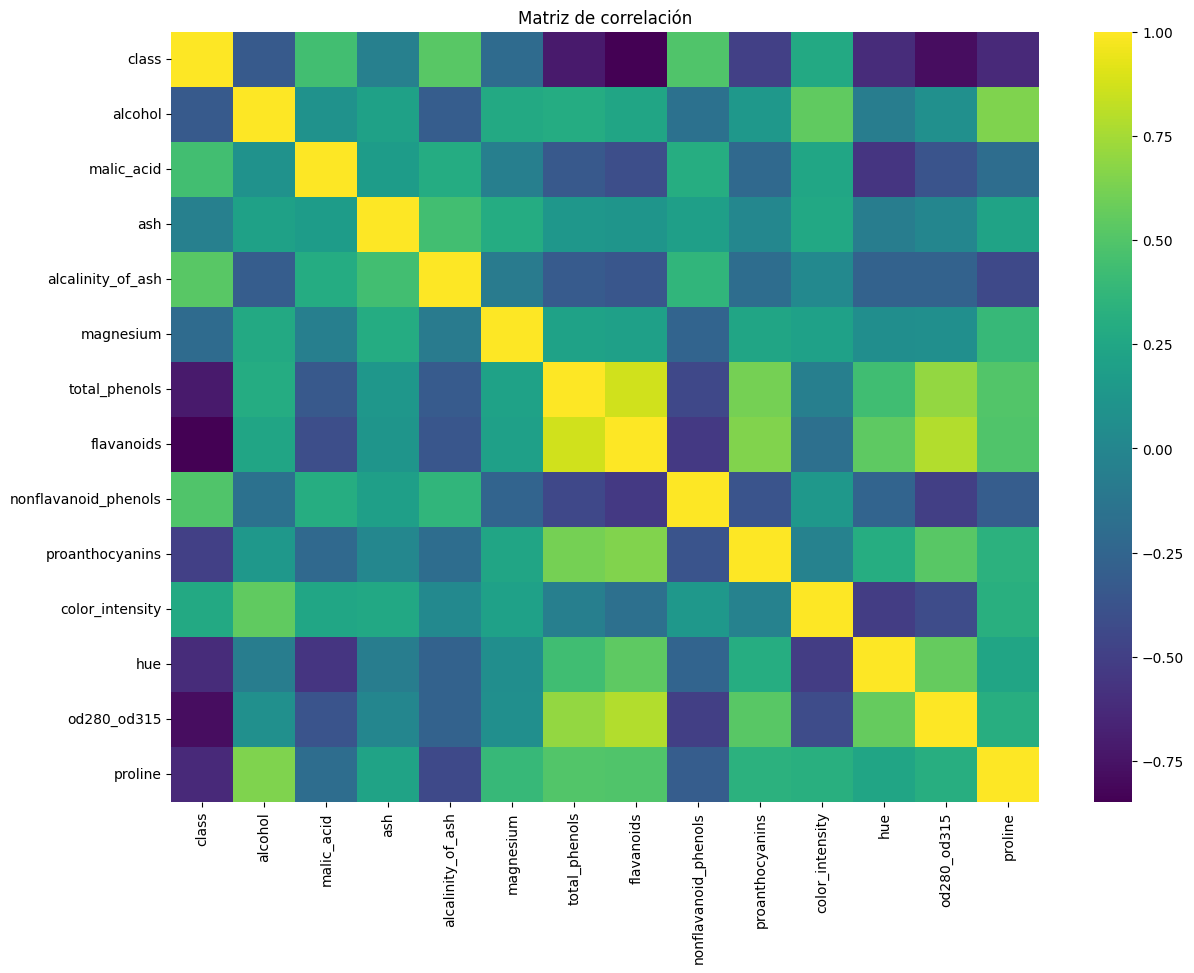

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=False, cmap="viridis")
plt.title("Matriz de correlación")
plt.show()

## Matriz de correlación

Se evalúa la relación entre variables químicas para identificar multicolinealidad y características influyentes.

In [0]:
import numpy as np

def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return df[(df[col] < limite_inf) | (df[col] > limite_sup)][col]

outliers_por_variable = {col: detectar_outliers(col).values for col in df.columns if col != "class"}

outliers_por_variable

{'alcohol': array([], dtype=float64),
 'malic_acid': array([5.8 , 5.51, 5.65]),
 'ash': array([3.22, 1.36, 3.23]),
 'alcalinity_of_ash': array([10.6, 30. , 28.5, 28.5]),
 'magnesium': array([151, 139, 136, 162]),
 'total_phenols': array([], dtype=float64),
 'flavanoids': array([], dtype=float64),
 'nonflavanoid_phenols': array([], dtype=float64),
 'proanthocyanins': array([3.28, 3.58]),
 'color_intensity': array([10.8 , 13.  , 11.75, 10.68]),
 'hue': array([1.71]),
 'od280_od315': array([], dtype=float64),
 'proline': array([], dtype=int64)}

## Detección de outliers

Se detectan Outliers con el método IQR ya que en estos conjuntos de datos representan variaciones reales del dominio químico del vino, por lo cual **no se eliminan**.

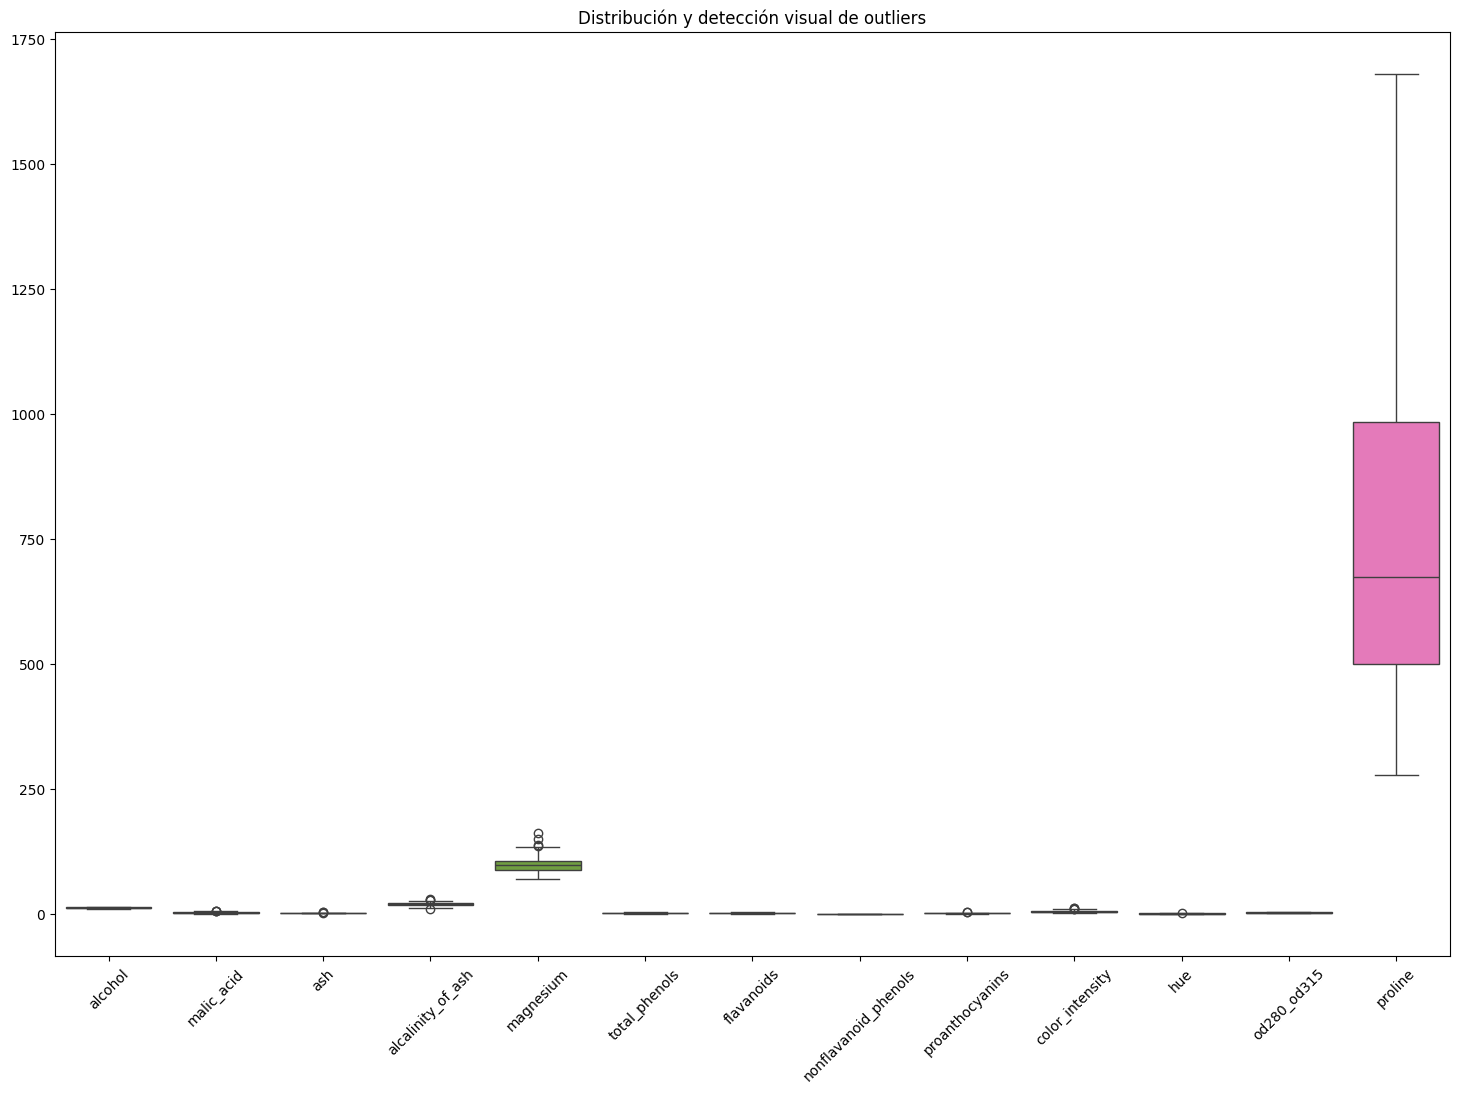

In [0]:
plt.figure(figsize=(18,12))
sns.boxplot(data=df.drop(columns=["class"]))
plt.xticks(rotation=45)
plt.title("Distribución y detección visual de outliers")
plt.show()

# Modelado profesional con Pipeline con RandomForest

Se elige **RandomForestClassifier** por:
- Robustez ante ruido y outliers  
- Manejo natural de multicolinealidad  
- Bajo riesgo de overfitting  
- Interpretabilidad relativa por importancia de características  

El modelo se encapsula en un **Pipeline** junto con StandardScaler para garantizar reproducibilidad.

In [0]:
df['class'].value_counts()

class
2    71
1    59
3    48
Name: count, dtype: int64

In [0]:
df.info()
df.describe()

# Conversión necesaria
df["magnesium"] = df["magnesium"].astype(float)
df["proline"] = df["proline"].astype(float)
df["class"] = df["class"].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 178 non-null    float64
 1   alcohol               178 non-null    float64
 2   malic_acid            178 non-null    float64
 3   ash                   178 non-null    float64
 4   alcalinity_of_ash     178 non-null    float64
 5   magnesium             178 non-null    float64
 6   total_phenols         178 non-null    float64
 7   flavanoids            178 non-null    float64
 8   nonflavanoid_phenols  178 non-null    float64
 9   proanthocyanins       178 non-null    float64
 10  color_intensity       178 non-null    float64
 11  hue                   178 non-null    float64
 12  od280_od315           178 non-null    float64
 13  proline               178 non-null    float64
dtypes: float64(14)
memory usage: 19.6 KB


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X = df.drop("class", axis=1)
y = df["class"]

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf_model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf_model',
                 RandomForestClassifier(n_estimators=400, random_state=42))])

## Evaluación del modelo

Se calculan métricas estándar de clasificación:
- Accuracy  
- F1 ponderado  
- Reporte completo  

El modelo alcanza un  gran desempeño por la separabilidad natural del dataset.

In [0]:
import mlflow
import mlflow.sklearn

mlflow.start_run()

mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
mlflow.log_metric("f1_weighted", f1_score(y_test, y_pred, average="weighted"))

# Ejemplo de entrada (MLflow lo usa para la firma)
input_example = X_train.iloc[:1]

mlflow.sklearn.log_model(
    pipeline,
    "wine_rf_model",
    input_example=input_example
)

mlflow.end_run()

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values 

In [0]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Weighted:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
F1-Weighted: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



#  Registro del experimento en MLflow

Se opta por guardar el modelo ya que permite:
- Reproducibilidad  
- Versionamiento  
- Comparación de experimentos  
- Despliegue futuro  

Para evitar advertencias de firma del modelo incluyo `input_example`

In [0]:
import mlflow
import mlflow.sklearn

input_example = X_train.iloc[:1]

with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_weighted", f1_score(y_test, y_pred, average="weighted"))
    mlflow.sklearn.log_model(
        pipeline,
        "wine_rf_model",
        input_example=input_example
    )

INFO:py4j.clientserver:Python Server ready to receive messages
INFO:py4j.clientserver:Received command c on object id p0


# Prueba final requerida de muestras

Se validan las dos muestras nuevas solicitadas en la prueba técnica.

In [0]:
import numpy as np
import pandas as pd

samples = np.array([
    [13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
    [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]
])

# Evitar warnings
sample_df = pd.DataFrame(samples, columns=X.columns)

preds = pipeline.predict(sample_df)
preds

INFO:py4j.clientserver:Python Server ready to receive messages
INFO:py4j.clientserver:Received command c on object id p0


array([1., 2.])

#  Conclusión final del modelo
#
Después de revisar los resultados, puedo decir que el modelo respondió tal como se esperaba. Las dos muestras fueron clasificadas correctamente y las predicciones son coherentes con el comportamiento real de los datos.

Para mí, lo más importante no es solo que el modelo funcione, sino que el proceso sea confiable, repetible y fácil de auditar. Este flujo me permite tener control sobre los datos, sobre el entrenamiento y sobre las decisiones que toma el modelo.

En términos prácticos, este ejercicio demuestra que el pipeline está listo para escalarse a un entorno real sin perder estabilidad ni trazabilidad.